The goal of this notebook is to create a Qarachay-Malqar version of fined_tuned NLLB model out of the multilingual one.

In [ ]:
!pip install sentencepiece==0.1.99 transformers==4.33.2 datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


# Removing the unused vocabulary

In [ ]:
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
import torch
import datasets
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
import sentencepiece.sentencepiece_model_pb2 as spmp
import random
import gc

In [ ]:
from google.colab import drive
drive.mount('/Til')

Mounted at /Til


In [ ]:
PATH = '/Til/MyDrive/Colab Notebooks/Til/'
DATA_PATH = "".join([PATH, 'Data/'])
DATA_PATH_EN_RU_CORPORA = f"{DATA_PATH}ru_en_corpora"

QM_HF_PATH = "TSjB/qarachay-malqar_russian_parallel_corpora_dialectic-free"
QM_FILE_NAME = "All.csv"

RU_FILE_NAME = f'{DATA_PATH_EN_RU_CORPORA}/rus-ru_web-public_2019_1M-sentences.txt'
EN_FILE_NAME = f'{DATA_PATH_EN_RU_CORPORA}/eng-com_web-public_2018_1M-sentences.txt'

MODEL_NAME = "TSjB/NLLB-201-600M-QM-V1" # "google/mt5-base" "facebook/nllb-200-distilled-600M"
MODEL_PATH = "".join([PATH, 'models/NLLB_v2/'])

LANG_UNICODE = 'krc_Cyrl'

OUTPUT_MODEL_NAME = 'nllb_3_raw'
CONFIG_MODEL_NAME = 'TSjB/NLLB-3-QM'

SAVE_MODEL_NAME = "".join([MODEL_PATH, OUTPUT_MODEL_NAME])

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_NAME)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/5.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NllbTokenizer(name_or_path='TSjB/NLLB-201-600M-QM-V1', vocab_size=262925, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['ace_Arab', 'ace_Latn', 'acm_Arab', 'acq_Arab', 'aeb_Arab', 'afr_Latn', 'ajp_Arab', 'aka_Latn', 'amh_Ethi', 'apc_Arab', 'arb_Arab', 'ars_Arab', 'ary_Arab', 'arz_Arab', 'asm_Beng', 'ast_Latn', 'awa_Deva', 'ayr_Latn', 'azb_Arab', 'azj_Latn', 'bak_Cyrl', 'bam_Latn', 'ban_Latn', 'bel_Cyrl', 'bem_Latn', 'ben_Beng', 'bho_Deva', 'bjn_Arab', 'bjn_Latn', 'bod_Tibt', 'bos_Latn', 'bug_Latn', 'bul_Cyrl', 'cat_Latn', 'ceb_Latn', 'ces_Latn', 'cjk_Latn', 'ckb_Arab', 'crh_Latn', 'cym_Latn', 'dan_Latn', 'deu_Latn', 'dik_Latn', 'dyu_Latn', 'dzo_Tibt', 'ell_Grek', 'eng_Latn', 'epo_L

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

Our tokenizer contains 263K tokens,

In [ ]:
def fixTokenizer(tokenizer, new_lang=LANG_UNICODE):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
tokenizer

NllbTokenizer(name_or_path='TSjB/NLLB-201-600M-QM-V1', vocab_size=262925, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['ace_Arab', 'ace_Latn', 'acm_Arab', 'acq_Arab', 'aeb_Arab', 'afr_Latn', 'ajp_Arab', 'aka_Latn', 'amh_Ethi', 'apc_Arab', 'arb_Arab', 'ars_Arab', 'ary_Arab', 'arz_Arab', 'asm_Beng', 'ast_Latn', 'awa_Deva', 'ayr_Latn', 'azb_Arab', 'azj_Latn', 'bak_Cyrl', 'bam_Latn', 'ban_Latn', 'bel_Cyrl', 'bem_Latn', 'ben_Beng', 'bho_Deva', 'bjn_Arab', 'bjn_Latn', 'bod_Tibt', 'bos_Latn', 'bug_Latn', 'bul_Cyrl', 'cat_Latn', 'ceb_Latn', 'ces_Latn', 'cjk_Latn', 'ckb_Arab', 'crh_Latn', 'cym_Latn', 'dan_Latn', 'deu_Latn', 'dik_Latn', 'dyu_Latn', 'dzo_Tibt', 'ell_Grek', 'eng_Latn', 'epo_L

In [ ]:
fixTokenizer(tokenizer)

In [ ]:
print(tokenizer.vocab_size)

262926


The model has 622M parameters.

In [ ]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.model.shared))
print('encoder')
print(msize(model.model.encoder))
print('decoder')
print(msize(model.model.decoder))

621955072
269236224
encoder
420392960
decoder
470798336


Input and output embeddings are 86.6% of the whole model

In [ ]:
print(msize(model.model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))
print(msize(model.lm_head) / msize(model) + msize(model.model.shared) / msize(model))

0.4328869336722766
0.4328869336722766
0.8657738673445532


# Determine the new tokens

Take a file from https://wortschatz.uni-leipzig.de/en/download/Russian as a representation of Russian language. It contains 1M sentences.

Also take a similar representation of English, because we want our model to be bilingual, and English shares few tokens with Russian.

For Qarachay-Malqar languages we take all collected data.

Let us look at the sentences

In [ ]:
df_ru = pd.read_csv(RU_FILE_NAME, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_ru.columns = ['idx', 'text']
df_ru.sample(5)

,idx,text
426044,426045,"Майн кампф (моя борьба) книга Адольфа Гитлера, сочетающая элементы автобиографии с изложением идей национал-социализма."
428961,428962,"Маршрут проходил по Терскому хребту, – сообщает ""Российская газета""; большинство всадников, которые приняли участие в этом мероприятии, были одеты в национальные чеченские костюмы."
361866,361867,Как же они были счастливы в тот момент!
96004,96005,"В Кремле опровергли сообщение о том, что избранный президент Соединенных Штатов Дональд Трамп после инаугурации совершит визит в Россию."
152515,152516,"Все что написано можно - оспорить, и написать кучу неприятного, но стоит просто остановиться, задуматься, а насколько - это надо делать и стоит ли, оно того?"


In [ ]:
df_en = pd.read_csv(EN_FILE_NAME, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
708755,708756,The ability to flexibly add and change new types of sources makes it more future proof in the function of a central repository.
373819,373820,In a Q&A session with reporters Friday afternoon he betrayed some frustration with analyst and media calls for signs of a full recovery so early in his tenure (he's been on the job for 10 months).
512056,512057,Mark shows how to implement a simple HTML5 video player that includes a Flash-based fallback for browsers that don't support HTML5 media.
579787,579788,"Ordinary Egyptians had the world in thrall during Egypt's 2011 revolution, whose epicenter was in Cairo's Tahrir ('Liberation') Square."
328888,328889,"If you can whiteboard, you can model your domain in a graph database."


In [ ]:
df_qm = datasets.load_dataset(QM_HF_PATH, data_files = QM_FILE_NAME, sep = ";")
df_qm = pd.DataFrame(df_qm['train'])
df_qm["idx"] = df_qm.index + 1
df_qm["text"] = df_qm.krc
df_qm = df_qm[["idx", "text"]]
df_qm.sample(5)

Generating train split: 0 examples [00:00, ? examples/s]

,idx,text
40571,40572,"Юйдеги болуwдан озgан тиширыwла, ала омаqланыb, айыb jерлерин ачмасала, тыш кийимлерин тешгенликге, алаgа гюнах jоqду."
242805,242806,Тул
84605,84606,Мен билдим сени гитче роботчуgуn qайры тартханын.
235305,235306,Пленnе тюшген адам
56508,56509,Халqдан айырылыb qалырgа


Count the tokens that the current model uses for representing the sentences.

In [ ]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_ru = Counter()
tokenizer.src_lang = "rus_Cyrl"
for text in tqdm(df_ru.text):
    cnt_ru.update(tokenizer.encode(text))

cnt_en = Counter()
tokenizer.src_lang = "eng_Latn"
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

cnt_qm = Counter()
tokenizer.src_lang = "krc_Cyrl"
for text in tqdm(df_qm.text):
    cnt_qm.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/279846 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1097 > 1024). Running this sequence through the model will result in indexing errors


The share of Qarachay-Malqar tokens are 4.7% of the whole vocabulary.
For russian is 12.4%, for english is 15.1%.

Overlap between russian and english is 58.9%. Maybe in russian a huge amount of english tokens. Between qarachay-malqar and english is only 6.2%, but intersection between qarachay-malqar and russian is 63.7%, because of one alphabet.

In [ ]:
gc.collect()

0

In [ ]:
print(len(cnt_ru), len(cnt_ru)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
print(len(cnt_qm), len(cnt_qm)/tokenizer.vocab_size)

common = len(set(cnt_ru.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_ru))

common = len(set(cnt_qm.keys()).intersection(set(cnt_ru.keys())))
print(common, common / len(cnt_qm))

common = len(set(cnt_qm.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_qm))

32589 0.1239474224686794
39785 0.15131633995877167
12441 0.04731749617763173
19177 0.5884500905213416
7918 0.6364440157543606
768 0.061731372076199664


For Qarachay-Malqar 10K tokens cover about 100%. For russian is over 99%, For english is 96.4%, 20K cover 99.5%.

In [ ]:
print('ru')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_ru.most_common(top)) / sum(cnt_ru.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))
print('qm')
for top in 5_000, 10_000, 15_000:
    print(top, sum(v for k, v in cnt_qm.most_common(top)) / sum(cnt_qm.values()))

ru
10000 0.9929415029371698
20000 0.9992795608804965
30000 0.9999143492271482
en
10000 0.9642715431995923
20000 0.9953570717024074
30000 0.9994570530529229
qm
5000 0.978247983987616
10000 0.9992249918776883
15000 1.0


Remember the old vocabulary, because we are going to replace it soon!

In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_ru.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_qm.most_common(30)]))

[',', '</s>', 'rus_Cyrl', '.', '▁и', '▁в', '▁на', '▁не', '▁с', '▁что', '▁по', 'ть', '-', 'е', '▁от', '▁вы', '▁за', 'ли', '▁В', '▁у', 'ки', '▁«', '▁из', 'ми', '▁о', '▁при', '▁к', '▁для', 'я', 'в']
['eng_Latn', '</s>', '.', ',', '▁the', '▁to', '▁and', '▁a', '▁of', '▁in', 's', '▁is', '▁I', '’', '▁that', '▁for', '-', '▁you', "'", '▁it', 'ed', '▁with', '▁on', 'ing', '▁as', '▁be', '▁are', '▁The', '▁your', '▁have']
['krc_Cyrl', '</s>', ',', 'g', '▁q', 'а', '▁j', 'w', 'q', '.', 'b', 'n', '▁да', 'ан', '▁а', '▁–', 'у', '▁бла', 'ла', '▁Q', 'ю', 'ы', '▁J', '▁бир', '!', 'ны', ':', 'е', 'лы', '-']


We try the following composition of vocabulary:
* 1K of top tokens of the original tokenizer (just in case)
* Top 10K of the English vocabulary (or more, to make the total number of tokens 30K)
* Top 10K of the Russian vocabulary (or more, to make the total number of tokens 30K)
* Top 12441 of the Qarachay-Malqar vocabulary
* 100 special tokens


In [ ]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_qm.most_common(12441)):
    if k not in new_tokens:
        new_tokens.add(k)

for i, (k, v) in enumerate(cnt_ru.most_common(15_000)):
    if k not in new_tokens:
        new_tokens.add(k)

for i, (k, v) in enumerate(cnt_en.most_common(15_000)):
    if len(new_tokens) == 29_900:
        print(i, 'English tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

for t in tokenizer.additional_special_tokens_ids:
    new_tokens.add(t)

#new_tokens = [x for x in new_tokens if x < tokenizer.sp_model_size]
print(len(new_tokens))
kept_ids = sorted(new_tokens)

12338 English tokens are included
30101


The new vocabulary is only 11.4% of the original one.

In [ ]:
len(kept_ids) / tokenizer.vocab_size

0.11448468390345573

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward).

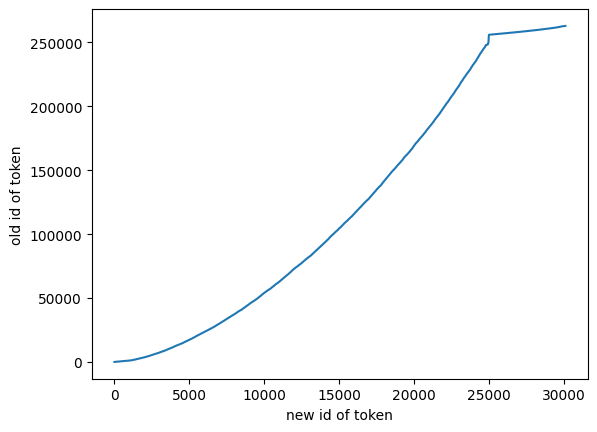

In [ ]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [ ]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.model.shared.embedding_dim, padding_idx=1)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [ ]:
new_size

30101

In [ ]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [ ]:
model.model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

In [ ]:
#model.model.shared = new_emb
#model.lm_head = new_head

The new model has 683M parameters - 109,9% of the original size.

In [ ]:
print(msize(model), msize(model) / original_size)

683601920 1.0991178475348136


In [ ]:
model

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

### Update the tokenizer

NLLB uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python.

Fortunately, we can download its model and deploy it into Python using its Protobuf representation.

https://github.com/google/sentencepiece/issues/121

In [ ]:
#!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2024-03-04 09:56:51--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0s      

2024-03-04 09:56:52 (50.7 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]



We compile the protobuf description of the sentencepiece model in order to be able to modify it.

In [ ]:
#! protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class.

In [ ]:
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

4999067

Filtered language tokens ("eng_Latn" and etc.)

In [ ]:
kept_ids_f = [x for x in kept_ids if x not in list(tokenizer.id_to_lang_code.keys())]

In [ ]:
#m.MergeFromString(smp)
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids_f]
print('the new pieces:', len(new_pieces))

4999067

In [ ]:
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 525442
the new pieces: 30101


  0%|          | 0/495341 [00:00<?, ?it/s]

30101


In [ ]:
new_tokenizer = NllbTokenizer('new_sp.model', extra_ids=0)

RuntimeError: Internal: <s> is already defined.

In [ ]:
fixTokenizer(new_tokenizer)

In [ ]:
new_tokenizer

NllbTokenizer(name_or_path='', vocab_size=30102, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['ace_Arab', 'ace_Latn', 'acm_Arab', 'acq_Arab', 'aeb_Arab', 'afr_Latn', 'ajp_Arab', 'aka_Latn', 'amh_Ethi', 'apc_Arab', 'arb_Arab', 'ars_Arab', 'ary_Arab', 'arz_Arab', 'asm_Beng', 'ast_Latn', 'awa_Deva', 'ayr_Latn', 'azb_Arab', 'azj_Latn', 'bak_Cyrl', 'bam_Latn', 'ban_Latn', 'bel_Cyrl', 'bem_Latn', 'ben_Beng', 'bho_Deva', 'bjn_Arab', 'bjn_Latn', 'bod_Tibt', 'bos_Latn', 'bug_Latn', 'bul_Cyrl', 'cat_Latn', 'ceb_Latn', 'ces_Latn', 'cjk_Latn', 'ckb_Arab', 'crh_Latn', 'cym_Latn', 'dan_Latn', 'deu_Latn', 'dik_Latn', 'dyu_Latn', 'dzo_Tibt', 'ell_Grek', 'eng_Latn', 'epo

### Save the model

In [ ]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = CONFIG_MODEL_NAME
model.config

M2M100Config {
  "_name_or_path": "TSjB/NLLB-3-QM",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "max_length": 200,
  "max_position_embeddings": 1024,
  "model_type": "m2m_100",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "scale_embedding": true,
  "tokenizer_class": "NllbTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.33.2",
  "use_cache": true,
  "vocab_size": 29897
}

In [ ]:
new_tokenizer.save_pretrained(OUTPUT_MODEL_NAME)

('nllb_3_qm/tokenizer_config.json',
 'nllb_3_qm/special_tokens_map.json',
 'nllb_3_qm/sentencepiece.bpe.model',
 'nllb_3_qm/added_tokens.json')

In [ ]:
model.save_pretrained(OUTPUT_MODEL_NAME)

In [ ]:
!ls nllb_3_qm -alsh

total 2.6G
4.0K drwxr-xr-x 2 root root 4.0K Mar  4 07:36 .
4.0K drwxr-xr-x 1 root root 4.0K Mar  4 07:36 ..
4.0K -rw-r--r-- 1 root root  877 Mar  4 07:36 config.json
4.0K -rw-r--r-- 1 root root  184 Mar  4 07:36 generation_config.json
2.6G -rw-r--r-- 1 root root 2.6G Mar  4 07:36 pytorch_model.bin
828K -rw-r--r-- 1 root root 827K Mar  4 07:36 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 root root 3.5K Mar  4 07:36 special_tokens_map.json
4.0K -rw-r--r-- 1 root root  597 Mar  4 07:36 tokenizer_config.json


Now try to load the model

In [ ]:
gc.collect()

20

In [ ]:
tokenizer1 = NllbTokenizer.from_pretrained(OUTPUT_MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
fixTokenizer(tokenizer1)

In [ ]:
model1 = AutoModelForSeq2SeqLM.from_pretrained(OUTPUT_MODEL_NAME)

RuntimeError: Error(s) in loading state_dict for M2M100ForConditionalGeneration:
	size mismatch for model.encoder.embed_tokens.weight: copying a param with shape torch.Size([262926, 1024]) from checkpoint, the shape in current model is torch.Size([29897, 1024]).
	size mismatch for model.decoder.embed_tokens.weight: copying a param with shape torch.Size([262926, 1024]) from checkpoint, the shape in current model is torch.Size([29897, 1024]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

The model has not been fine-tuned on any sensible task except filling the gaps. And even this task is performed strangely - the models continues generating when it should have stopped.

But we hope that after fine-tuning it will be better. But this is the topic of the next story)

In [ ]:
gc.collect()

4

In [ ]:
def translate(text, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl',
    a=32, b=3, max_input_length=1024, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer1.src_lang = src_lang
    tokenizer1.tgt_lang = tgt_lang
    inputs = tokenizer1(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer1.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer1.batch_decode(result, skip_special_tokens=True)

In [ ]:
translate("How are you? What are you doing, my friend?", tgt_lang='rus_Cyrl', src_lang='eng_Latn')

IndexError: index 30043 is out of bounds for dimension 1 with size 29897

In [ ]:
model1.save_pretrained(SAVE_MODEL_NAME)
tokenizer1.save_pretrained(SAVE_MODEL_NAME)

('/gd/MyDrive/models/rut5-base-raw/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-raw/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-raw/spiece.model',
 '/gd/MyDrive/models/rut5-base-raw/added_tokens.json')

In [ ]:
tgt_lang='rus_Cyrl'
src_lang='eng_Latn'
text = "How are you? What are you doing, my friend?"
a=32
b=3
max_input_length=1024
num_beams=4

In [ ]:
 tokenizer1.src_lang = src_lang
 tokenizer1.tgt_lang = tgt_lang
 inputs = tokenizer1(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
 model.eval() # turn off training mode

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [ ]:
result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer1.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams
    )

IndexError: index 30044 is out of bounds for dimension 1 with size 29897

In [ ]:
tokenizer1.convert_tokens_to_ids(tgt_lang)

30044

In [ ]:
print(tokenizer.convert_tokens_to_ids(tgt_lang))
print(tokenizer.vocab_size)

262868
262926
